# COVID-19 patient activity in Seoul

Reducing the contact with other people through social distancing or lockdown is a strategy that has been adopted by a wide range of countries in order to face the SARS‑CoV‑2 virus. Indeed, at the beginning of April 2020, [half the world population was in lockdown](https://www.euronews.com/2020/04/02/coronavirus-in-europe-spain-s-death-toll-hits-10-000-after-record-950-new-deaths-in-24-hou).

However, a _total_ lockdown of the population is not only psychologically impacting but can also be source of many [social inequalities](https://www.nytimes.com/2020/03/15/world/europe/coronavirus-inequality.html). Therefore, it seems fair to ask ourselves the question: is a _total_ lockdown always necessary? Wouldn't it be more profitable for the population of a country to develop more specific strategies of lockdown, so that some essential social factors remain?

__To answer this question, we will analyse and visualize the _PatientRoute_ data provided as part of the [Data Science for COVID-19 (DS4C)](https://www.kaggle.com/kimjihoo/coronavirusdataset) challenge, and try to identify what social activities represent higher risks in terms of virus propagation and need to be stopped, and those that have a lower propagation risk and can therefore be maintained for social benefits__. This dataset contains information about the activities of infected patients registered in South Korea between the 22nd of January and the 17th of February 2020. The data is available over the whole country of South Korea but, in order to make the analysis adapted to the scale of a city, it has been filtered on the capital city, Seoul.

More precisely, available patient activity entries contain a _patient id_ , a _date_ , _geographical coordinates (longitude, latitude)_ and an _activity type_ (e.g. going to the hospital, using public transport, doing groceries, ...). For practicality matters, __patient activity types have been classified into five main types__:
1. __Health__: hospital visit, pharmacy visit
2. __Travel__: use of public transportation, airport visit
3. __Supply__: grocery store visit, bakery
4. __Education__: school visit, cybercafé visit
5. __Others__: all other types of activities, e.g. restaurant, church, café, bar, ...


In [1]:
types = ['health', 'transport', 'supplies', 'education', 'others']
types_dict = dict(zip(types, [x for x in range(5)]))

Types dictionary: `{'health': 0, 'transport': 1, 'supplies': 2, 'education': 3, 'others': 4}`

In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapefile as shp

import ipywidgets as widgets

import datetime


Bad key "text.kerning_factor" on line 4 in
C:\Users\jacqu\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Data preparation

In [4]:
# __Temporal reference:__ _days_index_
N = 87 #Number of days
days = [d for d in range(N)]
date_0 = '2020-01-22'
def get_next_date(date): return str(pd.to_datetime(date) + datetime.timedelta(days = 1))[:10]
dates = [date_0]
for d in range(N-1): dates.append(get_next_date(dates[-1]))
days2dates_dict = dict(zip(days, dates))

In [5]:
# __Patient activities DataFrame:__ _pdf_
PatientRoute  = pd.read_csv('./data/PatientRoute.csv')
pdf  = PatientRoute[PatientRoute['province']== 'Seoul'].copy()

#Create temporal attributes
pdf['datetime'] = pd.to_datetime(pdf['date'])
pdf['days'] = (pdf.datetime-pdf.datetime.min()).apply(lambda td: td.days) #Days since first case

#Define patient activity groups
p1 = ['hospital', 'pharmacy'] #health
p2 = ['public_transportation', 'airport'] #transport
p3 = ['store', 'bakery'] #supplies
p4 = ['school', 'pc_cafe'] #education
ptypes = [p1, p2, p3, p4, [t for t in pdf.type.unique() if t not in p1+p2+p3+p4]]

#Classify patient activity type
def classify_ptype(x, types, ptypes):
    t = -1
    for i in range(len(types)):
        if x in ptypes[i]:
            t = i
    return t
pdf['ptype'] = pdf['type'].apply(lambda x: classify_ptype(x, types, ptypes))

# pdf.head()

In [6]:
# __Geographic districts DataFrame:__ _gdf_
def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#Read shapes of Seoul districts
gsf = shp.Reader('./data/seoul_municipalities.shp', encoding='gbk')
shapes = read_shapefile(gsf).rename(columns={'ESRI_PK': 'id', 'SIG_ENG_NM' : 'name'})
shapes['x'] = shapes.coords.apply(lambda L: [l[0] for l in L])
shapes['y'] = shapes.coords.apply(lambda L: [l[1] for l in L])
gdf = shapes[['id', 'name', 'x', 'y']].set_index('id')

#The Gangseo-gu shape (id 10) needs to be corrected
gdf.loc[10].x = gdf.loc[10].x[:-144].copy()
gdf.loc[10].y = gdf.loc[10].y[:-144].copy()

#Count the total activity level
data = PatientRoute[PatientRoute['province']== 'Seoul'].copy()
data.date = pd.to_datetime(data.date).copy()
data = data.groupby('city').count()[['patient_id']].reset_index().rename(columns={'patient_id' : 'total_count'})
gdf = gdf.merge(data, left_on='name', right_on='city')#[['name', 'x', 'y', 'total_count']]
gdf = gdf.drop(columns=['city'])

#Compute the total activity percentiles
p     = [10, 20, 40, 50, 60, 80, 90, 100]
p_val = np.percentile(gdf.total_count, p)
gdf['total_count_p'] = gdf.total_count.apply(lambda t: np.searchsorted(p_val, t))

# gdf.head()

To get a first sense of how the patient activity is spread over the city, it is useful to count how many activities have been registered in each district of the city over the whole period of time. For doing so, we can compute the [percentiles](https://en.wikipedia.org/wiki/Percentile) of the total number of activities in each district, and create an interactive map of the city of Seoul colored by total number of registered patient activity.

__The map is interactive, so try hovering over it and use the toolbar on the top to explore it yourself.__

In [7]:
from bokeh.io import push_notebook, curdoc, export_png, save
from bokeh.layouts import widgetbox, row, column
from bokeh.models import Column, ColumnDataSource, Slider, HoverTool, LinearColorMapper, BasicTicker, ColorBar, Dropdown
from bokeh.palettes import brewer
from bokeh.plotting import figure, save, show, output_notebook
output_notebook()

Loading BokehJS ...

In [8]:
#Set figure parameters
fig_options = {
    'title': 'COVID-19 patients activity in Seoul, all dates',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 850,
    'toolbar_location' : "above"
}

#Set district parameters
palette = brewer['YlGnBu'][8][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : {'field' :'total_count_p', 'transform' : color_mapper},
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.9
}

#Set colorbar parameters
tick_labels = {'0':'0', '1':'37', '2':'44', '3': '71', '4':'87', '5':'90', '6':'131', '7': '149', '8':'231'}
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

#Set data
geosource = ColumnDataSource(gdf)

#Create color bar
color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Create figure
p = figure(**fig_options)

#Plot districts
geo = p.patches('x', 'y', source = geosource, **geo_parameters)

#Add hover tool
hover = HoverTool()
hover.tooltips = [('District', '@name'), ('Activities registered' , '@total_count')]
p.add_tools(hover)
p.add_layout(color_bar, 'right')

#Display in notebook and show
show(p)

From this first map, what we can tell is that some districts of the city have a much higher activity level that others.  Gangnam-gu (in the South-East of the city) has registered a total number of 231 infected patient activities, which is considerably lower than in the neighbour district Gwangjin-gu which totals only 24 patient activities.

This could be a first hint towards different social behaviours in the neighborhoods. To investigate this further, it would be interesting to know about the general activities that take place in each district. Is this a residential district? A business district? A nightlife district?

In order to distinguish district types, [OpenStreetMaps data](http://download.geofabrik.de/) can be added to the map to __get information about the type of buildings in each district__. In a similar way than with the patient activity types, building types will be classified into 5 main types:
1. __Health__: hospitals, pharmacies, ...
2. __Travel__: train stations, bus stations, ...
3. __Supply__: supermarkets, retail stores, ...
4. __Education__: universities, schools, libraries, ...
5. __Others__: other types of buildings such as restaurant, churches, hotels, ...

__These building types are represented in map below, which is also interactive, so you can use the toolbar on the top and try zooming into it to see details of the buildings and their types. The legend is interactive as well, so simply click on it to filter out/in certain types of buildings.__

In [9]:
# __OpenStreetMaps buildings DataFrame:__ _bdf_
# Read shapefiles
bsf = shp.Reader('./data/buildings.shp')
df = read_shapefile(bsf)

#Format longitude and latitude attributes
df['x'] = df.coords.apply(lambda x: np.array(x)[:,0] )
df['y'] = df.coords.apply(lambda x: np.array(x)[:,1] )
df['x_m'] = df.x.apply(lambda x: np.mean(x))
df['y_m'] = df.y.apply(lambda x: np.mean(x))

#Select building whose center is in the area of Seoul
mask1 = (df['x_m'] >= 126.755) & (df['x_m'] <= 127.2)
mask2 = (df['y_m'] >= 37.42) & (df['y_m'] <= 37.71)

#Define building types
g1 = ['hospital', 'medical'] #health
g2 = ['train_station', 'station', 'transportation'] #travel
g3 = ['retail', 'service',  'supermarket'] #Supply
g4 = ['university', 'school', 'kindergarten', 'college',  'library', 'academy'] #education
g5 = ['hotel', 'church', 'museum', 'cathedral', 'temple',  'chapel', 'restaurant', 'police station'] #others
btypes = [g1, g2, g3, g4, g5]

#Select the buildings types defined
mask3 = pd.Series(len(df)*[False])
for g in btypes:
    for a in g: mask3 = mask3 | (df['type'] == a)

#Classify buildings
def classify_btype(x, types, btypes):
    t = -1
    for i in range(len(types)):
        if x in btypes[i]:
            t = i
    return t


bdf = df[mask1 & mask2 & mask3].reset_index()[['type', 'x', 'y']]
bdf['btype'] = bdf['type'].apply(lambda x: classify_btype(x, types, btypes))
# bdf.head()

In [10]:
#Set figure parameters
fig_options = {
    'title': 'Different building types in Seoul',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 800,
    'toolbar_location' : "above"
}

#Set district parameters
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : '#ffffd9',
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.9
}


#Set building parameters
bld_parameters1 = {
    'legend_label' : 'Health',
    'fill_color' : '#db5f57',
    'line_color' : '#db5f57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters2 = {
    'legend_label' : 'Travel',
    'fill_color' : '#b9db57',
    'line_color' : '#b9db57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters3 = {
    'legend_label' : 'Supply',
    'fill_color' : '#57db94',
    'line_color' : '#57db94',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters4 = {
    'legend_label' : 'Education',
    'fill_color' : '#5784db',
    'line_color' : '#5784db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters5 = {
    'legend_label' : 'Others',
    'fill_color' : '#c957db',
    'line_color' : '#c957db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}


#Set colorbar parameters
tick_labels = dict(zip([str(x) for x in range(9)], ['0']+[str(int(x)) for x in p_val]))
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

p = figure(**fig_options)

#Select initial data
gcols = ['name', 'x', 'y']
# pcols = ['patient_id', 'city', 'ptype', 'type', 'latitude', 'longitude', 'days']
bcols = ['btype', 'x', 'y']
geosource = ColumnDataSource(gdf[gcols])
# patsource = ColumnDataSource(pdf[pcols])
bldsource1 = ColumnDataSource(bdf[bdf['btype'] == 0][bcols])
bldsource2 = ColumnDataSource(bdf[bdf['btype'] == 1][bcols])
bldsource3 = ColumnDataSource(bdf[bdf['btype'] == 2][bcols])
bldsource4 = ColumnDataSource(bdf[bdf['btype'] == 3][bcols])
bldsource5 = ColumnDataSource(bdf[bdf['btype'] == 4][bcols])

#Plot
geo = p.patches('x', 'y', source = geosource, **geo_parameters)
bld1 = p.patches('x', 'y', source = bldsource1, **bld_parameters1)
bld2 = p.patches('x', 'y', source = bldsource2, **bld_parameters2)
bld3 = p.patches('x', 'y', source = bldsource3, **bld_parameters3)
bld4 = p.patches('x', 'y', source = bldsource4, **bld_parameters4)
bld5 = p.patches('x', 'y', source = bldsource5, **bld_parameters5)

# pat = p.circle(x='longitude', y='latitude',  source=patsource, **pat_parameters)
# color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Add tools
hover = HoverTool()
hover.tooltips = [('District', '@name'), ('(lng, lat)' , '($x, $y)')]
p.add_tools(hover)
# p.add_layout(color_bar, 'right')

#Make legend interactive
p.legend.click_policy = 'hide'

# #Show plot
show(p)

What can be seen from this map is that there are many buildings of the activity type _5. others_ in the district of Gangnam-gu, way more than in the district of Gwanjin-gu. This suggests that Gangnam-gu is a very active district in terms of social life.

Similarly, Yongsan-gu is the district with most _2. Travel_ related buildings, which suggests that it is a very well connected district, where many people come a go. This also makes sense because of the central position of Yongsan-gu.

__It now makes sense to merge all these data sources into a single interactive map to get a full overview__.

For doing so, we implemented an interactive map with three main layers:
1. __Districts colored by number of patient activities registered__
2. __Buildings colored by building type__
3. __Precise patient activity locations represented by red dots__

In [11]:
#Count the number of patient movements per day for each district
data = PatientRoute[PatientRoute['province'] == 'Seoul']
data = data.groupby(['city', 'date']).count()[['patient_id']].unstack().fillna(0)
data.columns = data.columns.droplevel(0)
data = data.reset_index()
gdf = gdf.merge(data, left_on='name', right_on='city').drop(columns=['city'])
gdf['2020-02-04'] = np.zeros(len(gdf)) #Add missing date (no movement recorded)
gdf = gdf.rename(columns=dict(zip(dates, ['mov_%d' %(d) for d in range(N)])))
gdf['mov'] = gdf.mov_0.copy()

#Get the max number of movements within a district for each day
mmov = PatientRoute[PatientRoute['province'] == 'Seoul']
mmov = mmov.groupby(['city', 'date']).count()[['patient_id']].unstack().fillna(0).max(axis=0)

#Compute percentiles of mmov for each day and district
p     = [10, 20, 40, 50, 60, 80, 90, 100]
p_val = np.percentile(mmov, p)
for d in days:
    gdf['p_mov_%d' %(d)] = gdf['mov_%d' %(d)].apply(lambda x: np.searchsorted(p_val, x))
gdf['p_mov'] = gdf.p_mov_0.copy()

# gdf.head()

In [13]:
#Set figure parameters
fig_options = {
    'title': 'COVID-19 patients activity in Seoul',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 850,
    'toolbar_location' : "above"
}

#Set district parameters
palette = brewer['YlGnBu'][8][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : {'field' :'p_mov', 'transform' : color_mapper},
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.9
}

#Set patient parameters
pat_parameters = {
    'legend_label' : 'Patients',
    'size' : 5, 
    'color' : 'red', 
    'line_color' : None, 
    'fill_alpha' : 1
}

#Set building parameters
bld_parameters1 = {
    'legend_label' : 'Hospitals',
    'fill_color' : '#db5f57',
    'line_color' : '#db5f57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters2 = {
    'legend_label' : 'Travel',
    'fill_color' : '#b9db57',
    'line_color' : '#b9db57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters3 = {
    'legend_label' : 'Supply',
    'fill_color' : '#57db94',
    'line_color' : '#57db94',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters4 = {
    'legend_label' : 'Education',
    'fill_color' : '#5784db',
    'line_color' : '#5784db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters5 = {
    'legend_label' : 'Others',
    'fill_color' : '#c957db',
    'line_color' : '#c957db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

#Set colorbar parameters
tick_labels = dict(zip([str(x) for x in range(9)], ['0']+[str(int(x)) for x in p_val]))
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

p = figure(**fig_options)

#Select initial data
gcols = ['name', 'x', 'y', 'mov', 'p_mov']
pcols = ['patient_id', 'city', 'ptype', 'type', 'latitude', 'longitude', 'days']
bcols = ['btype', 'x', 'y']
geosource = ColumnDataSource(gdf[gcols])
patsource = ColumnDataSource(pdf[pcols])
bldsource1 = ColumnDataSource(bdf[bdf['btype'] == 0][bcols])
bldsource2 = ColumnDataSource(bdf[bdf['btype'] == 1][bcols])
bldsource3 = ColumnDataSource(bdf[bdf['btype'] == 2][bcols])
bldsource4 = ColumnDataSource(bdf[bdf['btype'] == 3][bcols])
bldsource5 = ColumnDataSource(bdf[bdf['btype'] == 4][bcols])

#Plot
geo = p.patches('x', 'y', source = geosource, **geo_parameters)
bld1 = p.patches('x', 'y', source = bldsource1, **bld_parameters1)
bld2 = p.patches('x', 'y', source = bldsource2, **bld_parameters2)
bld3 = p.patches('x', 'y', source = bldsource3, **bld_parameters3)
bld4 = p.patches('x', 'y', source = bldsource4, **bld_parameters4)
bld5 = p.patches('x', 'y', source = bldsource5, **bld_parameters5)

pat = p.circle(x='longitude', y='latitude',  source=patsource, **pat_parameters)
color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Add tools
hover = HoverTool()
hover.tooltips = [('District', '@name'), ('(lng, lat)' , '($x, $y)'), ('Activity' , '@type')]
p.add_tools(hover)
p.add_layout(color_bar, 'right')

#Make legend interactive
p.legend.click_policy = 'hide'

#Create updating function
def update(day=0):
    p.title.text = fig_options['title'] + ', ' + days2dates_dict[day]
    
    #Update district data
    for col in ['mov', 'p_mov']:  
        geo.data_source.data[col] = gdf[col + '_' + str(day)]
        
    #Update patient data
    for col in ['latitude', 'longitude']: 
        pat.data_source.data[col] = pdf[pdf['days'] == day][col].copy()
        
    push_notebook()

# #Show plot
show(p, notebook_handle=True) #Uncomment for slider in notebook
# show(p)

#Activate and display widgets
day = widgets.IntSlider(min=0, max=86, step=1, value=0, style={'description_width': 'initial'} )

# top_box = widgets.HBox([widgets.Label('Days since 22nd of February: '), day])
ui = widgets.HBox([widgets.Label('Days since 22nd of February: '), day], layout=widgets.Layout(display='flex',flex_flow='column', border='solid 2px',align_items='stretch', width='50%'))

out = widgets.interactive_output(update, {'day' : day})
display(ui, out)

Output()

The map above has been combined with an slider to select the date, so that the district colors and patient activity locations adapt to the date selected. Unfortunately, the slider is a feature not yet supported by this website, and it is therefore not possible to use the map properly here. Instead, we recorded an animation of how the map behaves when sliding over the dates:

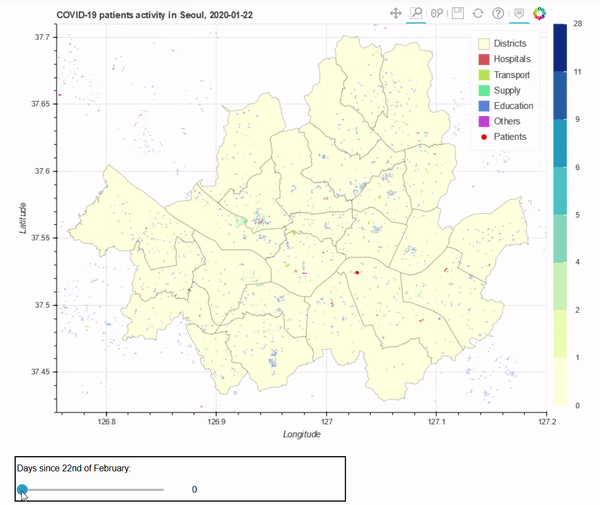

## Conclusions

From the final map, we concluded that some activities seem to have a higher risk of propagating the virus:
<font color=red>

* __Public transportation__: many patients have been registered using public transportation and the train, notably in the central train station of the Yongsan-gu district (try zooming into the final map to find out more)
* __Nightlife__: the district of Gangnam-gu has for instance the highest amount of total activity registered, and is mainly a nightlife neighborhood.
    
</font>

Other other hand, some activities seem to have a lower risk of propagating the virus:

<font color=green>

* __Education__:  to do ...
    
</font>


Therefore, if the authorities limit the ...
